In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

### Data Merging and Preparation 

In [301]:
trader_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

In [302]:
trader_df.shape

(211224, 16)

In [303]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [304]:
trader_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [305]:
sentiment_df.shape

(2644, 4)

In [306]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [307]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


### Data Cleaning and Type Conversion (Trader Data)

In [308]:
trader_df['timestamp_dt'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['trade_date'] = trader_df['timestamp_dt'].dt.date

In [309]:
trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')
trader_df.dropna(subset=['Closed PnL', 'Size USD', 'Account'], inplace=True)

**Data Cleaning and Type Conversion (Sentiment Data)**

In [310]:
sentiment_df['date_dt'] = pd.to_datetime(sentiment_df['date'], format='%Y-%m-%d')
sentiment_df['join_date'] = sentiment_df['date_dt'].dt.date

**Merging the Datasets**

In [311]:
merged_df = pd.merge(
    trader_df,
    sentiment_df[['join_date', 'classification','value']],
    left_on='trade_date',
    right_on='join_date',
    how='left'
)
merged_df.dropna(subset=['classification'], inplace=True)
merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,timestamp_dt,trade_date,join_date,classification,value
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,2024-12-02,Extreme Greed,80.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,2024-12-02,Extreme Greed,80.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02 22:50:00,2024-12-02,2024-12-02,Extreme Greed,80.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,2024-12-02,Extreme Greed,80.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02 22:50:00,2024-12-02,2024-12-02,Extreme Greed,80.0


In [312]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211218 entries, 0 to 211223
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211218 non-null  object        
 1   Coin              211218 non-null  object        
 2   Execution Price   211218 non-null  float64       
 3   Size Tokens       211218 non-null  float64       
 4   Size USD          211218 non-null  float64       
 5   Side              211218 non-null  object        
 6   Timestamp IST     211218 non-null  object        
 7   Start Position    211218 non-null  float64       
 8   Direction         211218 non-null  object        
 9   Closed PnL        211218 non-null  float64       
 10  Transaction Hash  211218 non-null  object        
 11  Order ID          211218 non-null  int64         
 12  Crossed           211218 non-null  bool          
 13  Fee               211218 non-null  float64       
 14  Trade ID 

### Trader Profiling: Calculate performance metrics for each account

In [313]:
# create a helper column to identify winning trades (PnL > 0)
profitable_trades = merged_df[merged_df['Closed PnL'] != 0].copy()
profitable_trades['is_winner'] = np.where(profitable_trades['Closed PnL'] > 0, 1, 0)
win_rate_stats = profitable_trades.groupby('Account')['is_winner'].mean().reset_index(name='win_rate')

In [314]:
# group by Account and aggregate metrics
trader_stats_df = merged_df.groupby('Account').agg(
    total_pnl=('Closed PnL', 'sum'),
    trade_count=('Transaction Hash', 'count'),
    average_trade_size_usd=('Size USD', 'mean'),
    pnl_volatility=('Closed PnL', 'std')
).reset_index()


In [315]:
# Calculate win rates separately and merge them in
trader_stats_df = trader_stats_df.merge(win_rate_stats, on='Account', how='left')
trader_stats_df['win_rate'].fillna(0, inplace=True) 
trader_stats_df['pnl_volatility'].fillna(0, inplace=True)

C:\Users\DIVYA K BANJARE\AppData\Local\Temp\ipykernel_39244\2642767972.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trader_stats_df['win_rate'].fillna(0, inplace=True)
C:\Users\DIVYA K BANJARE\AppData\Local\Temp\ipykernel_39244\2642767972.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [316]:
#small epsilon to avoid division by zero
trader_stats_df['pnl_volatility_ratio'] = trader_stats_df['total_pnl'] / (trader_stats_df['pnl_volatility'] * trader_stats_df['trade_count']**0.5 + 1e-6)

In [317]:
#Creating trader tiers based on total PnL
pnl_quantile_05 = trader_stats_df['total_pnl'].quantile(0.05)
pnl_quantile_95 = trader_stats_df['total_pnl'].quantile(0.95)

In [318]:
def assign_trader_tier(pnl):
    if pnl >= pnl_quantile_95: return 'Top 5%'
    elif pnl <= pnl_quantile_05: return 'Bottom 5%'
    else: return 'Average Trader'
trader_stats_df['trader_tier'] = trader_stats_df['total_pnl'].apply(assign_trader_tier)


In [319]:
final_analysis_df = merged_df.merge(trader_stats_df[['Account', 'trader_tier']], on='Account', how='left')


### Step 3: Hypothesis-Driven Analysis

In [320]:
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']


**Analysis 1: Core Question - Average PnL by Tier and Sentiment**


In [321]:
#Win Rate by Sentiment
win_rate_analysis = profitable_trades.merge(trader_stats_df[['Account', 'trader_tier']], on='Account', how='left')
win_rate_by_sentiment = win_rate_analysis.groupby(['trader_tier', 'classification'])['is_winner'].mean().reset_index()
print("\nAverage Win Rate by Tier and Sentiment:")
print(win_rate_by_sentiment.pivot(index='trader_tier', columns='classification', values='is_winner'))


Average Win Rate by Tier and Sentiment:
classification  Extreme Fear  Extreme Greed      Fear     Greed   Neutral
trader_tier                                                              
Average Trader      0.761707       0.898806  0.866048  0.792873  0.830842
Bottom 5%           0.952909       0.230769  0.903888  0.649123  0.492360
Top 5%              0.613793       0.791045  0.940686  0.649981  0.871910


In [322]:
# Statistical Validation: ANOVA Test
top_traders_pnl = final_analysis_df[final_analysis_df['trader_tier'] == 'Top 5%']
sentiment_groups = [top_traders_pnl['Closed PnL'][top_traders_pnl['classification'] == s] for s in sentiment_order]
f_stat, p_value = stats.f_oneway(*sentiment_groups)
print(f"\nANOVA test for Top 5% PnL across sentiment categories:")
print(f"F-statistic: {f_stat:.2f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: The differences in mean PnL across sentiment categories are statistically significant.")
else:
    print("Result: The differences in mean PnL are not statistically significant.")


ANOVA test for Top 5% PnL across sentiment categories:
F-statistic: 7.54, P-value: 0.0000
Result: The differences in mean PnL across sentiment categories are statistically significant.


### Advanced Visualizations

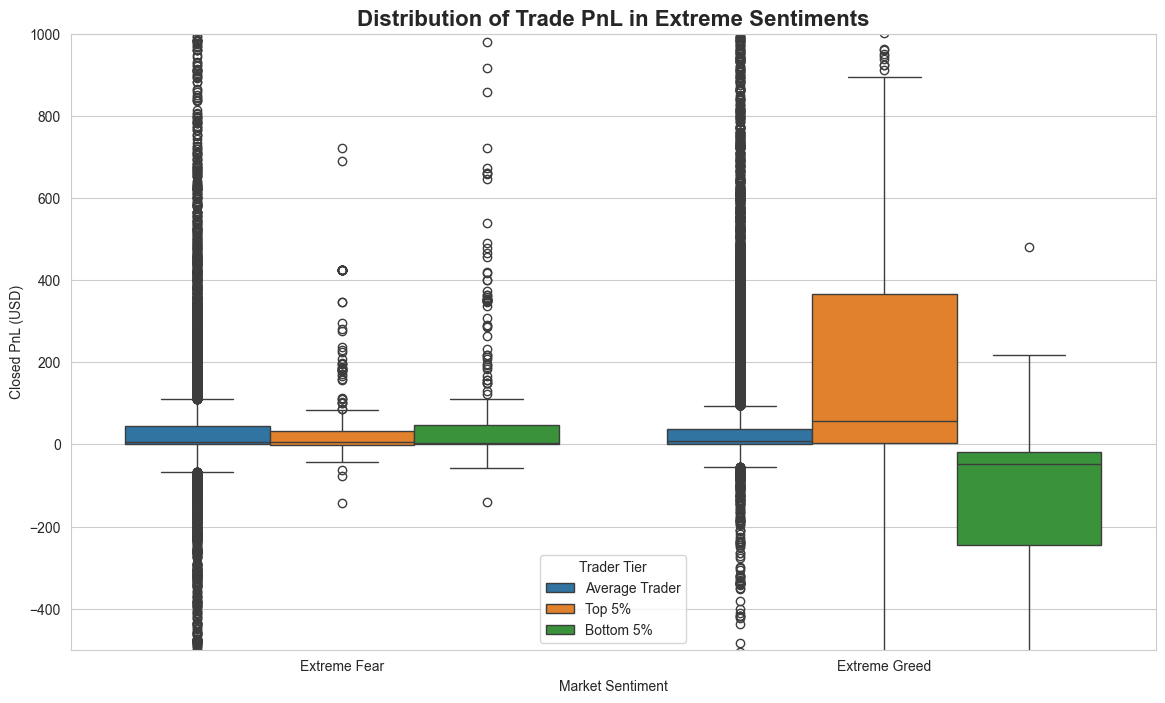

In [323]:
sns.set_style("whitegrid")
#Box Plot for PnL Distribution (Statistical Validation) ---
plt.figure(figsize=(14, 8))
extreme_sentiment_df = final_analysis_df[
    (final_analysis_df['classification'].isin(['Extreme Fear', 'Extreme Greed'])) &
    (final_analysis_df['Closed PnL'] != 0)
]
sns.boxplot(data=extreme_sentiment_df, x='classification', y='Closed PnL', hue='trader_tier', order=['Extreme Fear', 'Extreme Greed'])
plt.title('Distribution of Trade PnL in Extreme Sentiments', fontsize=16, fontweight='bold')
plt.ylabel('Closed PnL (USD)')
plt.xlabel('Market Sentiment')
plt.ylim(-500, 1000)
plt.legend(title='Trader Tier')
plt.savefig("advanced_viz_pnl_distribution.png")

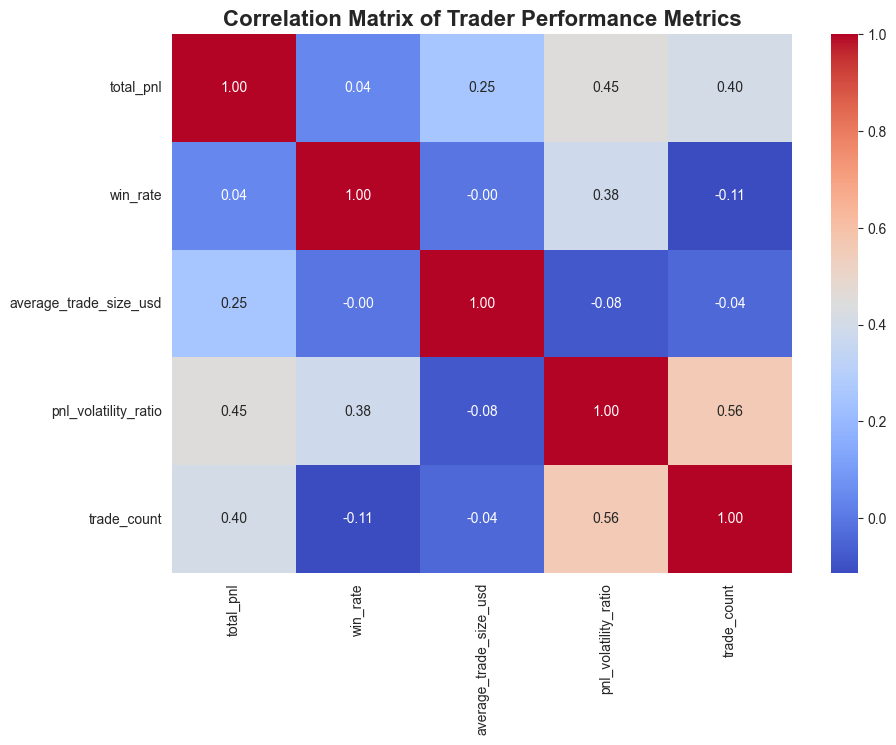

In [324]:
#Correlation Heatmap of Trader Metrics
plt.figure(figsize=(10, 7))
corr_matrix = trader_stats_df[['total_pnl', 'win_rate', 'average_trade_size_usd', 'pnl_volatility_ratio', 'trade_count']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Trader Performance Metrics', fontsize=16, fontweight='bold')
plt.savefig("advanced_viz_correlation_heatmap.png")

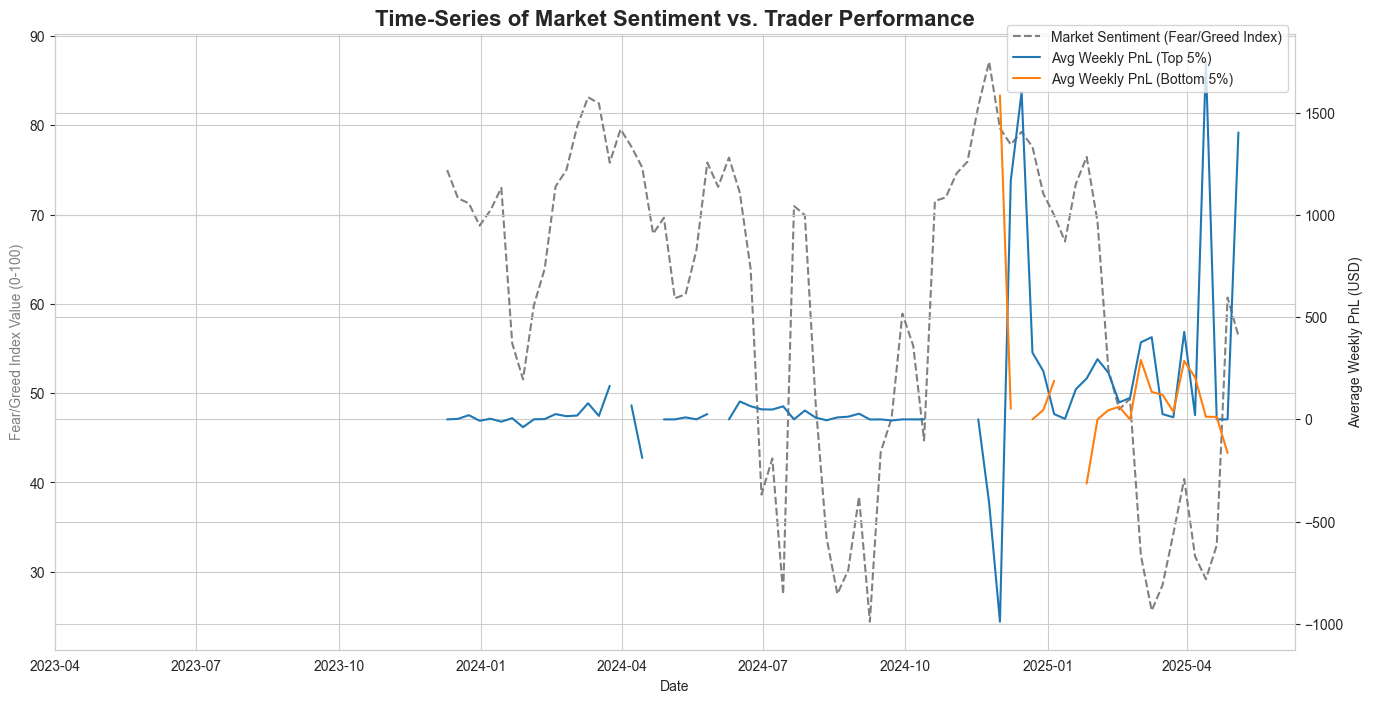

In [325]:
# Time-Series of Sentiment and PnL
# Resampling data by week
final_analysis_df['trade_date_dt'] = pd.to_datetime(final_analysis_df['trade_date'])
time_series_df = final_analysis_df.set_index('trade_date_dt')

weekly_pnl = time_series_df.groupby('trader_tier').resample('W')['Closed PnL'].mean()
weekly_sentiment = time_series_df['value'].resample('W').mean()

fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx() 
ax1.plot(weekly_sentiment.index, weekly_sentiment.values, color='gray', linestyle='--', label='Market Sentiment (Fear/Greed Index)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fear/Greed Index Value (0-100)', color='gray')

for tier in ['Top 5%', 'Bottom 5%']:
    pnl_data = weekly_pnl[tier]
    ax2.plot(pnl_data.index, pnl_data.values, label=f'Avg Weekly PnL ({tier})')
ax2.set_ylabel('Average Weekly PnL (USD)')

plt.title('Time-Series of Market Sentiment vs. Trader Performance', fontsize=16, fontweight='bold')
fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.9))
plt.savefig("advanced_viz_time_series.png")

In [326]:
cluster_features = ['total_pnl', 'win_rate', 'average_trade_size_usd', 'pnl_volatility_ratio', 'trade_count']
X = trader_stats_df[cluster_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [327]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
trader_stats_df['cluster'] = kmeans.fit_predict(X_scaled)
cluster_analysis = trader_stats_df.groupby('cluster')[cluster_features].mean()
print("\nAnalysis of Trader Clusters (Grouped by Behavior):")
print(cluster_analysis)
print("\nCrosstab of PnL Tiers vs. Behavioral Clusters:")
print(pd.crosstab(trader_stats_df['trader_tier'], trader_stats_df['cluster']))



Analysis of Trader Clusters (Grouped by Behavior):
            total_pnl  win_rate  average_trade_size_usd  pnl_volatility_ratio  \
cluster                                                                         
0        1.653198e+05  0.939368             3212.644544              7.873304   
1        1.074681e+06  0.867911             2873.337035             15.527550   
2        8.691713e+04  0.716015             4557.120689              2.091063   
3        6.930292e+05  0.854610            22539.720976              5.944440   

          trade_count  
cluster                
0         3961.357143  
1        21500.500000  
2         4128.100000  
3         7119.000000  

Crosstab of PnL Tiers vs. Behavioral Clusters:
cluster          0  1  2  3
trader_tier                
Average Trader  14  3  8  3
Bottom 5%        0  0  2  0
Top 5%           0  1  0  1
